In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spks import *

%matplotlib widget

#### Workaround for having modified the kilosort clusters with Phy

In [2]:
binary_path = Path('/home/data/GRB006/20240429_174359/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.bin')
fast_binary_path = Path('/scratch/GRB/temp_bin/ephys_g0_t0.imec0.ap.bin')
kilosort_path = Path('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/')

clu = Clusters(folder = kilosort_path, get_waveforms=False)
raw_data = RawRecording([fast_binary_path], return_preprocessed = False)
clu.extract_waveforms(data = raw_data, save_folder_path = clu.folder) # no filtering if using filtered binary

clu2 = Clusters(folder = kilosort_path, get_waveforms=True, load_template_features=True, get_metrics=True)


In [3]:
from spks.sync import load_ni_sync_data,interp1d
sessionpath = Path('/home/data/GRB006/20240429_174359/')
sync_port = 0 # this is where the SMA of the probe is connected

(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  

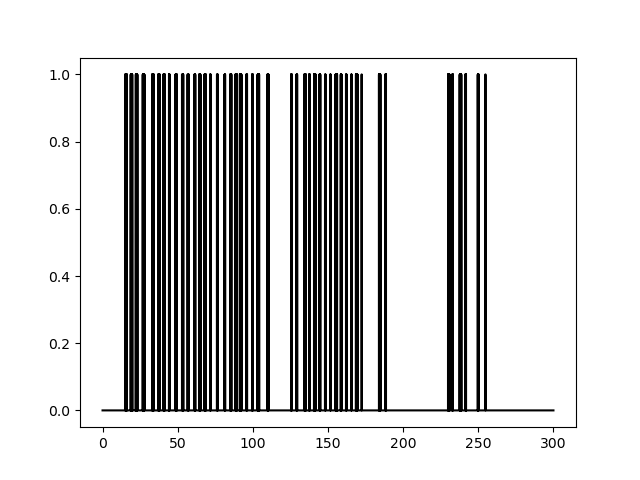

In [4]:
analog_signal = nisync[:, 0]
threshold = 15000
digital_signal = (analog_signal > threshold).astype(int)

t = nitime/srate
idx = t<300 #first # of seconds of the session
fig = plt.figure()
plt.plot(t[idx],digital_signal[idx],'k')

t = nitime/srate
idx = t<300 #first # of seconds of the session
fig = plt.figure()
plt.plot(t[idx],nisync[idx,0],'k')

In [5]:
sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy')
st = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy')

if sc.shape != st.shape:
    raise ValueError(f"The shapes of sc {sc.shape} and st {st.shape} are not the same")

df = pd.DataFrame({'spike_samples': st, 'spike_clusters': sc})
df['spike_times'] = df['spike_samples'] / srate
cluster_spike_times = df.groupby('spike_clusters').agg(spike_samples=('spike_samples', list), spike_times=('spike_times', list)).reset_index()

cluster_spike_times

,spike_clusters,spike_samples,spike_times
0,0,"[9997, 15600, 32753, 32970, 39220, 50507, 5148...","[0.3332333333333333, 0.52, 1.0917666666666668,..."
1,2,"[698153, 714662, 715686, 716191, 718687, 71919...","[23.271766666666668, 23.822066666666668, 23.85..."
2,4,"[698141, 708596, 708626, 709096, 709596, 71209...","[23.271366666666665, 23.619866666666667, 23.62..."
3,5,"[6722, 26797, 30008, 30446, 32035, 39693, 5318...","[0.22406666666666666, 0.8932333333333333, 1.00..."
4,6,"[707636, 708103, 713148, 714147, 715107, 71610...","[23.587866666666667, 23.603433333333335, 23.77..."
...,...,...,...
1083,1261,"[7436279, 11515784, 12916109, 13074652, 131372...","[247.87596666666667, 383.85946666666666, 430.5..."
1084,1262,"[526, 2145, 2942, 3342, 4162, 4785, 5025, 5180...","[0.017533333333333335, 0.0715, 0.0980666666666..."
1085,1266,"[1195996, 1268556, 2623557, 2818219, 2845725, ...","[39.86653333333334, 42.2852, 87.4519, 93.94063..."
1086,1268,"[842451, 11744111, 12596148, 12609692, 1318448...","[28.0817, 391.4703666666667, 419.8716, 420.323..."


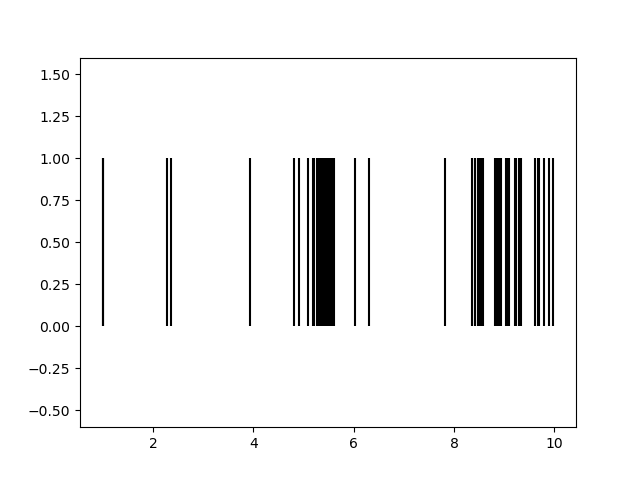

In [6]:
sp_times = np.array(cluster_spike_times.spike_times[7])
# sp_times[sp_times>300]

# Define the time window
start_time = 0  # Start of the time window
end_time = 10    # End of the time window

# Filter the spike times to include only those within the time window
filtered_sp_times = sp_times[(sp_times >= start_time) & (sp_times <= end_time)]

fig = plt.figure()
plt.eventplot(filtered_sp_times, lineoffsets=0.5, colors='black')


In [14]:
cluster_spike_times.spike_times

0       [0.3332333333333333, 0.52, 1.0917666666666668,...
1       [23.271766666666668, 23.822066666666668, 23.85...
2       [23.271366666666665, 23.619866666666667, 23.62...
3       [0.22406666666666666, 0.8932333333333333, 1.00...
4       [23.587866666666667, 23.603433333333335, 23.77...
                              ...                        
1083    [247.87596666666667, 383.85946666666666, 430.5...
1084    [0.017533333333333335, 0.0715, 0.0980666666666...
1085    [39.86653333333334, 42.2852, 87.4519, 93.94063...
1086    [28.0817, 391.4703666666667, 419.8716, 420.323...
1087    [0.012833333333333334, 0.5178666666666667, 0.5...
Name: spike_times, Length: 1088, dtype: object

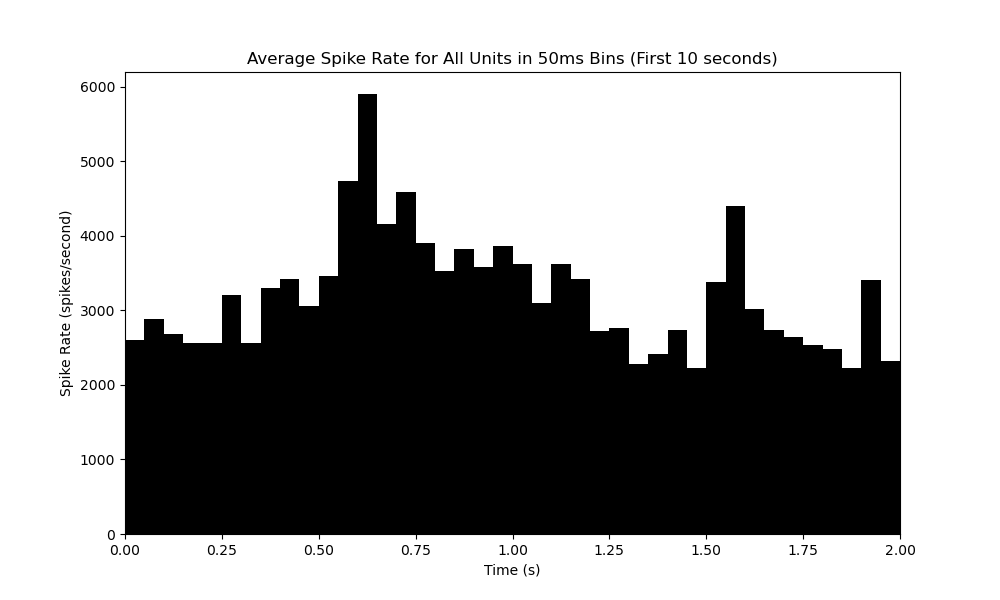

In [27]:
# Define the time window (first 10 seconds)
time_window = 2
# Define the bin size (50ms)
bin_size = 0.05

# Create an array of time bins
bins = np.arange(0, time_window + bin_size, bin_size)

# Initialize an array to hold the spike counts for each bin
bin_counts = np.zeros(len(bins) - 1)

# Loop through each unit's spike times
for unit_spike_times in cluster_spike_times['spike_times']:
    unit_spike_times = np.array(unit_spike_times)
    # Filter the spike times to include only those within the first 10 seconds
    spikes_in_window = unit_spike_times[unit_spike_times <= time_window]
    
    # Bin the spike times and add to the bin counts
    counts, _ = np.histogram(spikes_in_window, bins)
    bin_counts += counts

# Calculate the spike rates (spikes per second) for each bin
spike_rates = bin_counts / bin_size

# Create a time vector for plotting
time_bins = bins[:-1] + bin_size / 2

# Plot the spike rates
plt.figure(figsize=(10, 6))
plt.bar(time_bins, spike_rates, width=bin_size, align='center', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Spike Rate (spikes/second)')
plt.title('Average Spike Rate for All Units in 50ms Bins (First 10 seconds)')
plt.xlim(0, time_window)
plt.show()

In [40]:
stim_start_index = np.where((digital_signal[:-1] == 0) & (digital_signal[1:] == 1))[0][0] + 1
nitime[stim_start_index] / srate

15.135912

In [51]:
# Define the analysis window
pre_time = -1
post_time = 2
bin_size = 0.05

# Identify the start times of all stimulus events
stim_start_indices = np.where((digital_signal[:-1] == 0) & (digital_signal[1:] == 1))[0] + 1
stim_start_times = nitime[stim_start_indices] / srate
stim_start_times = stim_start_times[:100]

# Create an array of time bins for the window
bins = np.arange(pre_time, post_time + bin_size, bin_size)

# Initialize an array to hold the spike counts for each bin
all_bin_counts = np.zeros(len(bins) - 1)

# Loop through each stimulus event
for stim_start_time in stim_start_times:
    window_start = stim_start_time + pre_time
    window_end = stim_start_time + post_time
    time_shifted_bins = bins + stim_start_time
    
    bin_counts = np.zeros(len(time_shifted_bins) - 1)
    
    # Loop through each unit's spike times
    for unit_spike_times in cluster_spike_times['spike_times']:
        unit_spike_times = np.array(unit_spike_times)
        # Filter the spike times to include only those within the window
        spikes_in_window = unit_spike_times[(unit_spike_times >= window_start) & (unit_spike_times <= window_end)]
        
        # Bin the spike times and add to the bin counts
        counts, _ = np.histogram(spikes_in_window, time_shifted_bins)
        bin_counts += counts

    # Sum the bin counts across all stimulus events
    all_bin_counts += bin_counts

# Calculate the average spike rates (spikes per second) for each bin
spike_rates = all_bin_counts / (len(stim_start_times) * bin_size)

# Create a time vector for plotting relative to the stimulus event
time_bins = bins[:-1] + bin_size / 2

# Plot the spike rates
plt.figure(figsize=(10, 6))
plt.bar(time_bins, spike_rates, width=bin_size, align='center', color='black')
plt.xlabel('Time relative to stimulus event (s)')
plt.ylabel('Spike Rate (spikes/second)')
plt.title('Average Spike Rate Relative to All Stimulus Events (-1s to +2s)')
plt.xlim(pre_time, post_time)
plt.show()

KeyboardInterrupt: 

/tmp/ipykernel_11069/1163027999.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


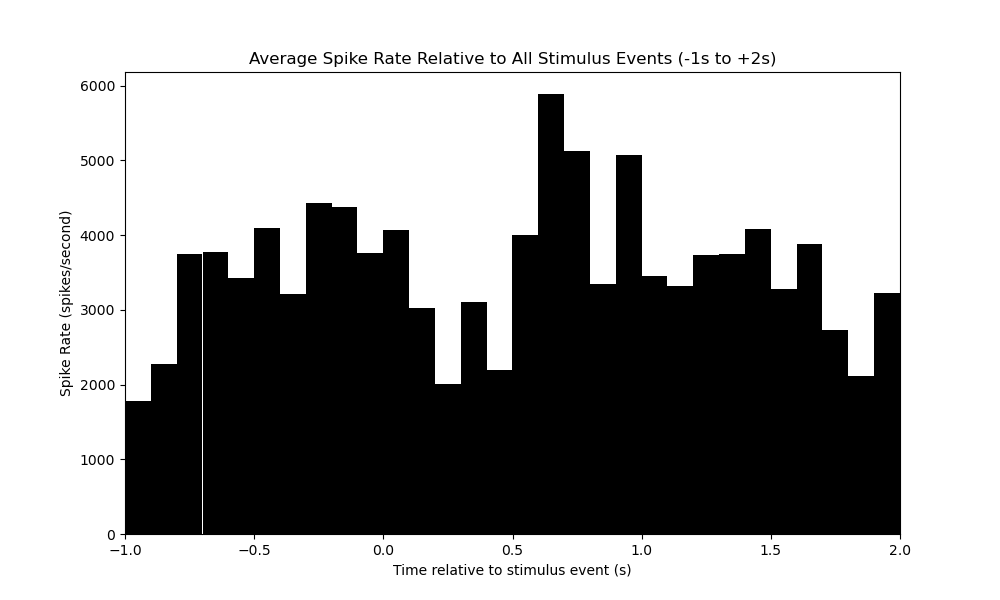

In [53]:
pre_time = -1
post_time = 2
bin_size = 0.1

# Identify the start times of all stimulus events
stim_start_indices = np.where((digital_signal[:-1] == 0) & (digital_signal[1:] == 1))[0] + 1
stim_start_times = nitime[stim_start_indices] / srate
stim_start_times = stim_start_times[:100]

# Create an array of time bins for the window
bins = np.arange(pre_time, post_time + bin_size, bin_size)
bin_counts_all_events = np.zeros(len(bins) - 1)

# Pre-compute the time bins shifted for each event
time_shifted_bins = np.add.outer(stim_start_times, bins)

# Loop through each unit's spike times and calculate spike counts for all events
for unit_spike_times in cluster_spike_times.spike_times:
    unit_spike_times = np.array(unit_spike_times)
    # Compute spike counts for all stimulus events
    for shifted_bins in time_shifted_bins:
        spikes_in_window = unit_spike_times[(unit_spike_times >= shifted_bins[0]) & (unit_spike_times <= shifted_bins[-1])]
        counts, _ = np.histogram(spikes_in_window, shifted_bins)
        bin_counts_all_events += counts

# Calculate the average spike rates (spikes per second) for each bin
spike_rates = bin_counts_all_events / (len(stim_start_times) * bin_size)

# Create a time vector for plotting relative to the stimulus event
time_bins = bins[:-1] + bin_size / 2

# Plot the spike rates
plt.figure(figsize=(10, 6))
plt.bar(time_bins, spike_rates, width=bin_size, align='center', color='black')
plt.xlabel('Time relative to stimulus event (s)')
plt.ylabel('Spike Rate (spikes/second)')
plt.title('Average Spike Rate Relative to All Stimulus Events (-1s to +2s)')
plt.xlim(pre_time, post_time)
plt.show()

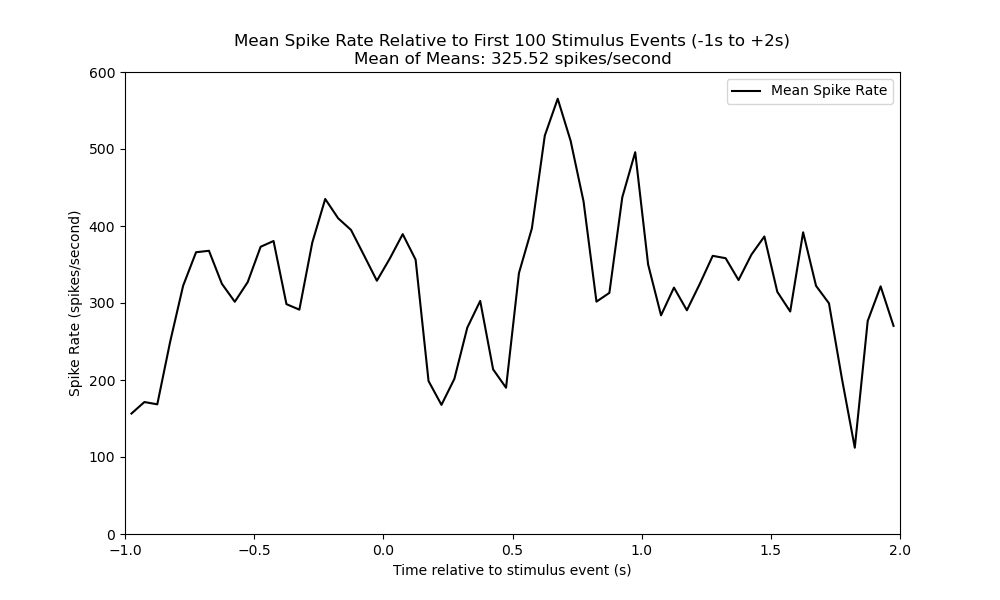

In [61]:
# Define the analysis window
pre_time = -1
post_time = 2
bin_size = 0.05

# Identify the start times of all stimulus events
stim_start_indices = np.where((digital_signal[:-1] == 0) & (digital_signal[1:] == 1))[0] + 1
stim_start_times = nitime[stim_start_indices] / srate

# Limit to the first 100 stimulus events
stim_start_times = stim_start_times[:100]

# Create an array of time bins for the window
bins = np.arange(pre_time, post_time + bin_size, bin_size)

# Initialize lists to hold the spike rates for each unit
all_unit_spike_rates = []

# Pre-compute the time bins shifted for each event
time_shifted_bins = np.add.outer(stim_start_times, bins)

# Loop through each unit's spike times
for unit_spike_times in cluster_spike_times.spike_times:
    unit_spike_times = np.array(unit_spike_times)
    bin_counts = np.zeros(len(bins) - 1)
    
    # Compute spike counts for all stimulus events for this unit
    for shifted_bins in time_shifted_bins:
        spikes_in_window = unit_spike_times[(unit_spike_times >= shifted_bins[0]) & (unit_spike_times <= shifted_bins[-1])]
        counts, _ = np.histogram(spikes_in_window, shifted_bins)
        bin_counts += counts
    
    # Calculate the spike rate (spikes per second) for this unit
    spike_rates = bin_counts / bin_size
    all_unit_spike_rates.append(spike_rates)

# Convert list to numpy array for easier manipulation
all_unit_spike_rates = np.array(all_unit_spike_rates)

# Calculate the mean spike rate and standard deviation for each bin
mean_spike_rates = all_unit_spike_rates.mean(axis=0)
std_spike_rates = all_unit_spike_rates.std(axis=0)

# Calculate the mean of the means
mean_of_means = mean_spike_rates.mean()

# Create a time vector for plotting relative to the stimulus event
time_bins = bins[:-1] + bin_size / 2

# Plot the mean spike rates with standard deviation as shaded area
plt.figure(figsize=(10, 6))
plt.plot(time_bins, mean_spike_rates, color='black', label='Mean Spike Rate')
# plt.fill_between(time_bins, mean_spike_rates - std_spike_rates, mean_spike_rates + std_spike_rates, color='gray', alpha=0.5, label='Std Dev')

plt.xlabel('Time relative to stimulus event (s)')
plt.ylabel('Spike Rate (spikes/second)')
plt.title(f'Mean Spike Rate Relative to First 100 Stimulus Events (-1s to +2s)\nMean of Means: {mean_of_means:.2f} spikes/second')
plt.xlim(pre_time, post_time)
plt.ylim([0, 600])
plt.legend()
plt.show()

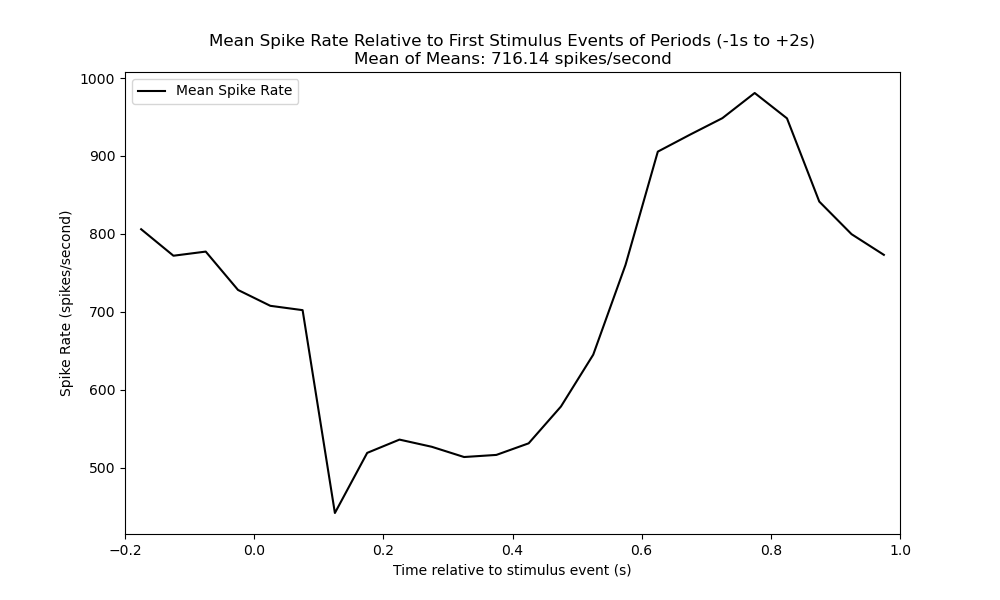

In [82]:
# Extract the IDs of the units to select
selected_unit_ids = single_units_df.cluster_id.values

# Create a mask for the spike clusters to filter the spike times
selected_spike_times = []
for unit_id in selected_unit_ids:
    mask = cluster_spike_times.spike_clusters == unit_id
    selected_spike_times.append(np.array(cluster_spike_times.spike_times[mask]))  # Ensure it is a flat numpy array

# Continue with your existing analysis using `selected_spike_times`

# Define the analysis window
pre_time = -0.2
post_time = 1
bin_size = 0.05

# Identify the start times of all stimulus events
stim_start_indices = np.where((digital_signal[:-1] == 0) & (digital_signal[1:] == 1))[0] + 1
stim_start_times = nitime[stim_start_indices] / srate

# Filter to keep only the first event in each stimulus period
stim_start_times_filtered = []
prev_time = -np.inf
for time in stim_start_times:
    if time - prev_time > 1:
        stim_start_times_filtered.append(time)
        prev_time = time

# Limit to the first 100 stimulus periods
stim_start_times_filtered = stim_start_times_filtered[:100]

# Create an array of time bins for the window
bins = np.arange(pre_time, post_time + bin_size, bin_size)

# Initialize lists to hold the spike rates for each unit
all_unit_spike_rates = []

# Pre-compute the time bins shifted for each event
time_shifted_bins = np.add.outer(stim_start_times_filtered, bins)

# Loop through each selected unit's spike times
for unit_spike_times in selected_spike_times:
    if len(unit_spike_times) == 0:
        continue  # Skip if the array is empty
    
    bin_counts = np.zeros(len(bins) - 1)
    
    # Ensure unit_spike_times is a flat numpy array
    unit_spike_times = np.concatenate(unit_spike_times) if isinstance(unit_spike_times[0], list) else np.array(unit_spike_times)
    
    # Compute spike counts for all stimulus events for this unit
    for shifted_bins in time_shifted_bins:
        spikes_in_window = unit_spike_times[(unit_spike_times >= shifted_bins[0]) & (unit_spike_times <= shifted_bins[-1])]
        counts, _ = np.histogram(spikes_in_window, shifted_bins)
        bin_counts += counts
    
    # Calculate the spike rate (spikes per second) for this unit
    spike_rates = bin_counts / bin_size
    all_unit_spike_rates.append(spike_rates)

# Convert list to numpy array for easier manipulation
all_unit_spike_rates = np.array(all_unit_spike_rates)

# Calculate the mean spike rate and standard deviation for each bin
mean_spike_rates = all_unit_spike_rates.mean(axis=0)
std_spike_rates = all_unit_spike_rates.std(axis=0)

# Calculate the mean of the means
mean_of_means = mean_spike_rates.mean()

# Create a time vector for plotting relative to the stimulus event
time_bins = bins[:-1] + bin_size / 2

# Plot the mean spike rates with standard deviation as shaded area
plt.figure(figsize=(10, 6))
plt.plot(time_bins, mean_spike_rates, color='black', label='Mean Spike Rate')
# plt.fill_between(time_bins, mean_spike_rates - std_spike_rates, mean_spike_rates + std_spike_rates, color='gray', alpha=0.5, label='Std Dev')

plt.xlabel('Time relative to stimulus event (s)')
plt.ylabel('Spike Rate (spikes/second)')
plt.title(f'Mean Spike Rate Relative to First Stimulus Events of Periods (-1s to +2s)\nMean of Means: {mean_of_means:.2f} spikes/second')
plt.xlim(pre_time, post_time)
plt.legend()
plt.show()

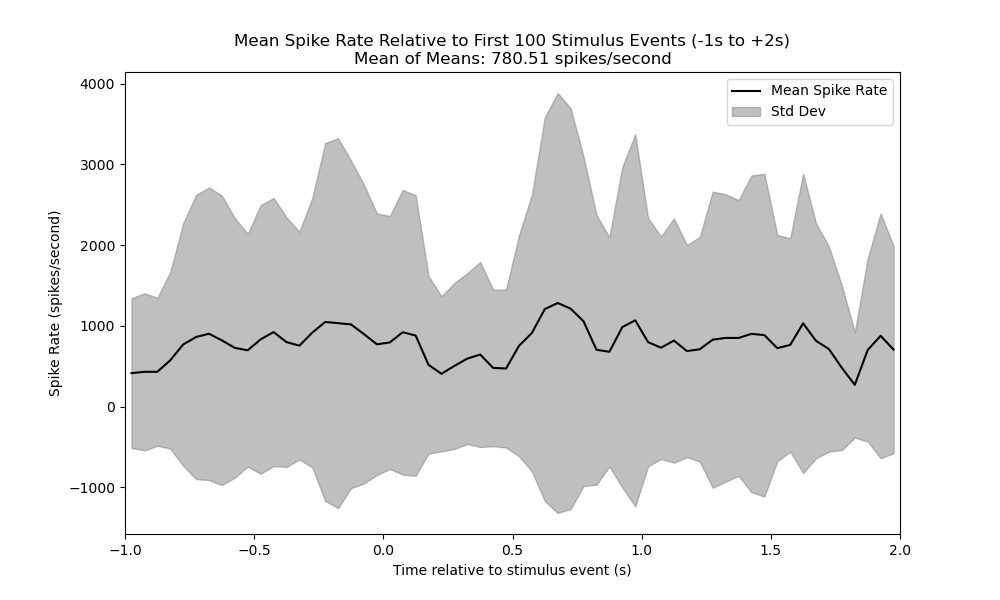

In [79]:
# Define the analysis window
pre_time = -1
post_time = 2
bin_size = 0.05

# Identify the start times of all stimulus events
stim_start_indices = np.where((digital_signal[:-1] == 0) & (digital_signal[1:] == 1))[0] + 1
stim_start_times = nitime[stim_start_indices] / srate

# Limit to the first 100 stimulus events
stim_start_times = stim_start_times[:100]

# Create an array of time bins for the window
bins = np.arange(pre_time, post_time + bin_size, bin_size)

# Initialize lists to hold the spike rates for each unit
all_unit_spike_rates = []

# Pre-compute the time bins shifted for each event
time_shifted_bins = np.add.outer(stim_start_times, bins)

# Loop through each selected unit's spike times
for unit_spike_times in selected_spike_times:
    if len(unit_spike_times) == 0:
        continue  # Skip if the array is empty
    
    bin_counts = np.zeros(len(bins) - 1)
    
    # Ensure unit_spike_times is a flat numpy array
    unit_spike_times = np.concatenate(unit_spike_times) if isinstance(unit_spike_times[0], list) else np.array(unit_spike_times)
    
    # Compute spike counts for all stimulus events for this unit
    for shifted_bins in time_shifted_bins:
        spikes_in_window = unit_spike_times[(unit_spike_times >= shifted_bins[0]) & (unit_spike_times <= shifted_bins[-1])]
        counts, _ = np.histogram(spikes_in_window, shifted_bins)
        bin_counts += counts
    
    # Calculate the spike rate (spikes per second) for this unit
    spike_rates = bin_counts / bin_size
    all_unit_spike_rates.append(spike_rates)

# Convert list to numpy array for easier manipulation
all_unit_spike_rates = np.array(all_unit_spike_rates)

# Calculate the mean spike rate and standard deviation for each bin
mean_spike_rates = all_unit_spike_rates.mean(axis=0)
std_spike_rates = all_unit_spike_rates.std(axis=0)

# Calculate the mean of the means
mean_of_means = mean_spike_rates.mean()

# Create a time vector for plotting relative to the stimulus event
time_bins = bins[:-1] + bin_size / 2

# Plot the mean spike rates with standard deviation as shaded area
plt.figure(figsize=(10, 6))
plt.plot(time_bins, mean_spike_rates, color='black', label='Mean Spike Rate')
plt.fill_between(time_bins, mean_spike_rates - std_spike_rates, mean_spike_rates + std_spike_rates, color='gray', alpha=0.5, label='Std Dev')

plt.xlabel('Time relative to stimulus event (s)')
plt.ylabel('Spike Rate (spikes/second)')
plt.title(f'Mean Spike Rate Relative to First 100 Stimulus Events (-1s to +2s)\nMean of Means: {mean_of_means:.2f} spikes/second')
plt.xlim(pre_time, post_time)
plt.legend()
plt.show()

# ---------- START HERE TOMORROW ----------

Now I have a dataframe where I have the spike times for each cluster. I can now filter out the clusters with the metrics I have 3 cells below to obtain a filtered dataframe. I also now have the frame times so I can begin to look at PSTHs soon

# ------------------------------------------------

In [63]:
clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

In [64]:
clu.cluster_info

,cluster_id,isi_contamination,firing_rate,presence_ratio,amplitude_cutoff,depth,electrode,shank,trough_time,trough_amplitude,fw3m,trough_gradient,peak_gradient,peak_time,peak_amplitude,spike_duration,polarity,n_active_channels,active_channels
0,0,0.160453,3.361094,1.00,0.500000,3056.513601,0,0,0.003169,-76.338954,0.195355,300.796902,22.183345,0.595235,21.397965,0.592067,-1,20,[ 0 1 2 3 4 5 6 8 179 180 181 1...
1,2,NaN,2.865344,0.86,0.124731,3131.811287,1,0,0.149852,-123.186841,0.415380,-0.076231,214.102380,1.449998,28.467085,1.300146,-1,288,[ 0 1 2 3 4 5 6 7 8 9 10 ...
2,4,NaN,4.397314,0.85,0.000520,3130.875112,141,1,0.124516,128.652046,0.244694,-619.353687,87.002118,0.124516,128.652046,NaN,1,315,[ 0 1 2 3 4 5 6 7 8 9 10 ...
3,5,0.130397,3.107188,1.00,0.500000,3061.817930,1,0,-0.020834,-66.857853,0.230693,161.447431,76.219097,0.582901,21.474642,0.603735,-1,21,[ 0 1 2 3 4 5 6 7 8 9 11 1...
4,6,NaN,1.851485,0.84,0.018290,3137.055670,1,0,0.006836,182.015954,0.338038,-275.015886,-379.445802,0.006836,182.015954,NaN,1,350,[ 0 1 2 3 4 5 6 7 8 9 10 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,1253,NaN,0.225367,0.82,0.500000,3135.439985,96,0,-0.032168,-200.227408,0.030670,-4333.826794,17.631946,0.027505,123.925876,0.059673,-1,383,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1081,1254,0.000000,0.073259,0.53,0.500000,3135.868575,127,1,0.068176,-257.430856,0.029670,-1684.351181,87.964052,0.112848,17.291538,0.044672,-1,383,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1082,1255,NaN,0.226250,0.74,0.500000,3127.726365,135,1,0.149852,-126.296158,0.247028,865.999866,-214.579270,0.490890,98.492809,0.341038,-1,314,[ 0 1 2 3 5 6 7 8 9 11 13 ...
1083,1256,NaN,0.172703,0.62,0.318414,3150.537775,148,1,-0.012166,-117.095513,0.270030,314.135582,21.653092,0.919272,38.357426,0.931438,-1,107,[ 1 9 11 17 22 25 37 39 40 41 46 ...


In [66]:
single_units_df = clu.cluster_info[
    (np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50) 
    & (clu.cluster_info.amplitude_cutoff < 0.1) 
    & (clu.cluster_info.isi_contamination < 0.1)
    & (clu.cluster_info.presence_ratio >= 0.6)
    & (clu.cluster_info.spike_duration > 0.1)
]

single_units_df.cluster_id

7          9
10        12
12        14
13        15
21        24
        ... 
1068    1241
1070    1243
1073    1246
1078    1251
1084    1257
Name: cluster_id, Length: 231, dtype: int64

In [70]:
cluster_spike_times[cluster_spike_times.spike_clusters == single_units_df.cluster_id.values]

ValueError: Can only compare identically-labeled Series objects

In [ ]:
def plot_cluster_info_histograms(clu):
    # Setup
    fig, axs = plt.subplots(3, 2, tight_layout=True, figsize=(10, 6))
    n_bins = 50

    # Calculate the total number of neurons
    total_neurons = len(clu.cluster_info)

    # Calculate the excluded samples
    excluded_peak_amplitude = np.sum(np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) <= 50)
    excluded_isi_contamination = np.sum(clu.cluster_info.isi_contamination > 0.1)
    excluded_spike_duration = np.sum(clu.cluster_info.spike_duration <= 0.1)
    excluded_presence_ratio = np.sum(clu.cluster_info.presence_ratio <= 0.6)
    excluded_amplitude_cutoff = np.sum(clu.cluster_info.amplitude_cutoff > 0.1)

    # Set the figure title
    fig.suptitle(f'Total clusters: {total_neurons}\n Shaded area indicates excluded clusters by metric', fontsize=14)

    # ------- Plot histograms ------- #

    # spike amplitude
    axs[0, 0].hist(np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude), bins=n_bins, alpha=0.5, color='b')
    axs[0, 0].axvline(x=50, color='b', linestyle='--')
    axs[0, 0].fill_betweenx(y=axs[0, 0].get_ylim(), x1=max(axs[0, 0].get_xlim()[0], 0), x2=50, color='b', alpha=0.1)
    axs[0, 0].set_xlabel('spike amplitude')
    axs[0, 0].set_ylabel('counts')
    axs[0, 0].set_title(f'n = {excluded_peak_amplitude}')

    # ISI contamination
    axs[1, 0].hist(clu.cluster_info.isi_contamination, bins=n_bins, alpha=0.5, color='g')
    axs[1, 0].axvline(x=0.1, color='g', linestyle='--')
    axs[1, 0].fill_betweenx(y=axs[1, 0].get_ylim(), x1=0.1, x2=min(axs[1, 0].get_xlim()[1], axs[1, 0].get_xlim()[1]), color='g', alpha=0.1)
    axs[1, 0].set_xlabel('isi_contamination')
    axs[1, 0].set_ylabel('counts')
    axs[1, 0].set_title(f'n = {excluded_isi_contamination}')

    # spike duration
    axs[2, 0].hist(clu.cluster_info.spike_duration, bins=n_bins, alpha=0.5, color='r')
    axs[2, 0].axvline(x=0.1, color='r', linestyle='--')
    axs[2, 0].fill_betweenx(y=axs[2, 0].get_ylim(), x1=max(axs[2, 0].get_xlim()[0], 0), x2=0.1, color='r', alpha=0.1)
    axs[2, 0].set_xlabel('spike_duration')
    axs[2, 0].set_ylabel('counts')
    axs[2, 0].set_title(f'n = {excluded_spike_duration}')

    # presence ratio
    axs[0, 1].hist(clu.cluster_info.presence_ratio, bins=n_bins, alpha=0.5, color='orange')
    axs[0, 1].axvline(x=0.6, color='orange', linestyle='--')
    axs[0, 1].fill_betweenx(y=axs[0, 1].get_ylim(), x1=max(axs[0, 1].get_xlim()[0], 0), x2=0.6, color='orange', alpha=0.1)
    axs[0, 1].set_xlabel('presence_ratio')
    axs[0, 1].set_ylabel('counts')
    axs[0, 1].set_title(f'n = {excluded_presence_ratio}')

    # amplitude cutoff
    axs[1, 1].hist(clu.cluster_info.amplitude_cutoff, bins=n_bins, alpha=0.5, color='purple')
    axs[1, 1].axvline(x=0.1, color='purple', linestyle='--')
    axs[1, 1].fill_betweenx(y=axs[1, 1].get_ylim(), x1=0.1, x2=min(axs[1, 1].get_xlim()[1], axs[1, 1].get_xlim()[1]), color='purple', alpha=0.1)
    axs[1, 1].set_xlabel('amplitude_cutoff')
    axs[1, 1].set_ylabel('counts')
    axs[1, 1].set_title(f'n = {excluded_amplitude_cutoff}')

    # depth - not used for filtering out clusters, but a helpful viz nonetheless
    axs[2, 1].hist(clu.cluster_info.depth, bins=n_bins, alpha=0.5, color='c')
    axs[2, 1].set_xlabel('depth')
    axs[2, 1].set_ylabel('counts')


plot_cluster_info_histograms(clu)

In [ ]:
# ---------- this gets the row indices ---------- #
single_unit_idx = np.where((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))[0]

# ---------- and this get the cluster_id values ---------- #
mask = ((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))


single_unit_ids = clu.cluster_info[mask].cluster_id.values

# single_unit_ids

In [ ]:
# single_unit_idx[single_unit_idx!=1084]

In [ ]:
units_spiketimes = clu.spike_times[np.isin(clu.spike_clusters,single_unit_idx)] 
units_spikeclusters = clu.spike_clusters[np.isin(clu.spike_clusters,single_unit_idx)]  

assert units_spiketimes.shape == units_spikeclusters.shape

In [ ]:
# CLUSTER_ID = 9
# good_spikes = good_spikes[good_clusters == CLUSTER_ID] # only get spikes from one cluster
# print(f'We will extract {len(good_spikes)} spikes for this cluster')

# # good_spikes = np.hstack((good_spikes + 30000, good_spikes + np.max(good_spikes) - 30000))
# print(good_spikes.shape)

In [ ]:
# import spks.waveforms as spwaves

# SCRATCH_DIR = '/scratch/GRB' # fast disk to write memmap file
# nchannels = raw_data.shape[1]

# waves = spwaves.extract_memmapped_waveforms(raw_data, SCRATCH_DIR, good_spikes[:100])
# waves.shape # (nspikes, nsamples, nchannels)

In [ ]:
# spike_times = read_phy_data(kilosort_path, srate=1, use_kilosort_results=True)['ts'] #ts = timestamps i think

In [ ]:
clu.load_waveforms()

In [ ]:
waves = load_dict_from_h5('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/cluster_waveforms.hdf')

In [ ]:
waves.keys()

In [ ]:
units_waves = [waves[i] for i in single_unit_ids]

In [ ]:
units_waves[0].shape

In [ ]:
channel_idx = raw_data.metadata[0]['channel_idx']
np.mean(units_waves[0][:,:,383], axis=0)

In [ ]:
from spks.phy_utils import read_phy_data
from spks.waveforms import extract_waveform_set

# spike_times = read_phy_data(kilosort_path, srate=1, use_kilosort_results=True)['ts'] #ts = timestamps i think
SCRATCH_DIR = '/scratch/GRB/temp_waves' # fast disk to write memmap file
nchannels = raw_data.shape[1]

# waves = extract_waveform_set(spike_times, raw_data, max_n_spikes=100)
# st = [spike_times[i] for i in single_unit_idx[single_unit_idx!=1084]]
waves = extract_waveform_set(units_spiketimes, raw_data, max_n_spikes=100, mmap_output=True, scratch_directory=SCRATCH_DIR)

In [ ]:
from ipywidgets import interact, IntSlider
from spks.viz import plot_footprints

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

@interact(clu_ids=IntSlider(min=0, max=len(units_waves)-1, step=1, value=0))
def g(clu_ids):
    ax.clear()

    channel_xy = raw_data.metadata[0]['coords']
    channel_idx = raw_data.metadata[0]['channel_idx']-1
    plot_footprints(np.mean(units_waves[clu_ids][:,:,channel_idx], axis=0), channel_xy, shade_color='k')

    return

In [ ]:
# weird clusters: 48, 79, 81, 83, 90, 91, 113, 115... there's actually a bunch of them

In [ ]:
single_unit_ids

In [ ]:
plt.figure(figsize=[12,5])
# plot the cluster waveforms accross all channels and overlay with the standard deviation
plot_footprints(clu.cluster_waveforms_mean[clu.cluster_id == 9],clu.channel_positions,
                shade_data = clu.cluster_waveforms_std[clu.cluster_id == 9].squeeze(), color='r');
# plt.axis((720, 805., 1407, 1677));

In [ ]:
# plot the principal channels for a set of clusters
# %matplotlib notebook
# plot some of the high amplitude clusters
clusters = clu.cluster_id[np.argsort(clu.trough_amplitude)[:5]]
for iclu,c in zip(clusters,['#d62728',
                            '#1f77b4',
                            '#ff7f0e',
                            '#2ca02c',
                            '#9467bd']):
    
    idx = clu.active_channels[clu.cluster_id == iclu][0]
    plot_footprints(clu.cluster_waveforms_mean[clu.cluster_id == iclu].squeeze()[:,idx],clu.channel_positions[idx,:],
                    color=c);
    
# plt.axis((718, 808, 1718, 2231));